<a href="https://colab.research.google.com/github/SimidolaLawani/Adclick/blob/main/Einsights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) What I executed (POC summary)

Generated synthetic half-hourly data for 4,000 MPXNs over 30 days (30 × 48 = 1440 timestamps per MPXN → 5,760,000 rows total, generated vectorized).

Used the appliance-share ratios you provided as a baseline allocation to split mains into 8 appliance categories.

Built a quick unsupervised clustering (KMeans) on normalized daily mains profiles to slightly adjust per-household shares (so the allocation adapts to household type).

(POC) Prepared a small Seq2Point CNN model to disaggregate Cooking — code included; model training requires TensorFlow. In the environment here, TensorFlow wasn’t installed so the Seq2Point training step was skipped, but I left the full code and instructions so you can run it in Colab.

Created cost calculation using Scottish Power-style rates:

Weekdays: £0.30 / kWh

Weekends: £0.15 / kWh (half-price)

Computed weekly & monthly costs per appliance and per MPXN.

Plotted donut charts for 5 random sample MPXNs (last month & last week) with total £ shown in the donut center.

Saved CSV reports to /mnt/data/poc_reports:

monthly_costs_per_mpxn_hybrid.csv

weekly_costs_per_mpxn_hybrid.csv

Note: In this environment TensorFlow was not available so I ran the pipeline without the Seq2Point-trained replacement (i.e., hybrid = clustering-adjusted allocation). The code includes the Seq2Point training steps and instructions to run them in Colab.

2) Files & sample charts

The run produced donut charts for 5 sample MPXNs (they were displayed).

CSV summary files (first 4,000 MPXNs) were written to /mnt/data/poc_reports.

In Colab this path is accessible via the file explorer; in other environments update the out_dir path.

3) How to run the full POC (recommended: Google Colab)

Copy the complete cell below into a Colab notebook. It installs dependencies, generates the synthetic data, runs the baseline + clustering pipeline, trains Seq2Point (if you want), and produces charts + CSVs.

If you only want the fast route (no TF): run the cell but skip the Seq2Point training cell (I show how to skip).
If you want Seq2Point: run the entire notebook — Colab will install TensorFlow and training will run (POC sized: small, a few epochs).

In [2]:
!pip install tensorflow

In [4]:
# INSTALL (run once at top of Colab)
!pip install pandas numpy matplotlib scikit-learn tensorflow

# Then run the POC pipeline below (single cell or split as you like).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import random, os
from datetime import datetime

# ---------- CONFIG ----------
N_MPXN = 4000
START = pd.Timestamp("2025-01-01 00:00:00")
END = pd.Timestamp("2025-01-30 23:30:00")  # 30 days
FREQ = "30T"
WEEKDAY_PRICE = 0.30
WEEKEND_PRICE = 0.15
APPLIANCES = [
    "Refrigeration","Cooking","Home Entertainment","Always On & Standby",
    "Laundry & Dish Washing","Lighting","Water Heating","Other"
]
BASE_SHARES = {
    "Refrigeration": 0.15, "Cooking": 0.20, "Home Entertainment": 0.10,
    "Always On & Standby": 0.10, "Laundry & Dish Washing": 0.15,
    "Lighting": 0.12, "Water Heating": 0.10, "Other": 0.08
}
# ---------- /CONFIG ----------
'''
rng = pd.date_range(START, END, freq=FREQ)
N_T = len(rng)

def make_base_profile(n_t):
    hours = np.array([(START + pd.Timedelta(i*30, unit='m')).hour for i in range(n_t)])
    profile = 0.5 + 0.4*np.sin((hours + 2)/24 * 2*np.pi) + 0.2*np.sin((hours*2)/24 * 2*np.pi)
    return np.clip(profile, 0.05, None)

base_profile = make_base_profile(N_T)
np.random.seed(0); random.seed(0)

# per-house scales and share noise
scales = np.random.uniform(0.6, 2.0, size=N_MPXN)
share_noise = np.random.normal(0.0, 0.03, size=(N_MPXN, len(APPLIANCES)))
base_share_arr = np.array([BASE_SHARES[a] for a in APPLIANCES])
shares = np.maximum(0.0, base_share_arr + share_noise)
shares = shares / shares.sum(axis=1, keepdims=True)

# mains (kWh per half-hour)
mains_matrix = np.outer(scales, base_profile) + np.random.normal(0,0.2,size=(N_MPXN,N_T))
mains_matrix = np.clip(mains_matrix, 0.01, None)

# Baseline allocation
appliance_matrix = mains_matrix[:, :, None] * shares[:, None, :]  # (N_MPXN, N_T, n_appl)

# price vector
df_time = pd.DataFrame({"Read_Date": rng})
df_time["dayofweek"] = df_time["Read_Date"].dt.dayofweek
df_time["unit_price"] = np.where(df_time["dayofweek"] < 5, WEEKDAY_PRICE, WEEKEND_PRICE)
price_vector = df_time["unit_price"].values

# cluster-adjusted shares (unsupervised improvement)
days = (rng.max() - rng.min()).days + 1
mains_daily = mains_matrix.reshape(N_MPXN, days, 48).mean(axis=1)
scaler = StandardScaler()
mains_daily_norm = scaler.fit_transform(mains_daily)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
clusters = kmeans.fit_predict(mains_daily_norm)

cluster_adjustments = np.zeros((n_clusters, len(APPLIANCES)))
for c in range(n_clusters):
    idx = np.where(clusters == c)[0]
    rel = mains_matrix[idx].mean() / mains_matrix.mean()
    adj = np.ones(len(APPLIANCES))
    adj[APPLIANCES.index("Cooking")] *= (1 + 0.1*(rel-1))
    adj[APPLIANCES.index("Laundry & Dish Washing")] *= (1 + 0.08*(rel-1))
    adj[APPLIANCES.index("Always On & Standby")] *= (1 - 0.05*(rel-1))
    cluster_adjustments[c] = np.clip(adj, 0.7, 1.3)

adjusted_shares = shares.copy()
for i in range(N_MPXN):
    c = clusters[i]
    adjusted_shares[i] = adjusted_shares[i] * cluster_adjustments[c]
    adjusted_shares[i] = np.maximum(0, adjusted_shares[i])
    adjusted_shares[i] = adjusted_shares[i] / adjusted_shares[i].sum()

appliance_matrix_adj = mains_matrix[:, :, None] * adjusted_shares[:, None, :]
cost_matrix_adj = appliance_matrix_adj * price_vector[None, :, None]

week_num = ((df_time["Read_Date"] - START).dt.days // 7).values
month_idx = df_time["Read_Date"].dt.to_period("M").astype(int).values
last_week_id = week_num.max()
last_month_id = month_idx.max()

weekly_cost_per_appl_adj = cost_matrix_adj[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_adj = cost_matrix_adj[:, month_idx == last_month_id, :].sum(axis=1)

# ---------- Seq2Point optional training (small POC) ----------
# If you want to run this, set DO_SEQ2POINT=True. It trains a small model for "Cooking" using synthetic windows.
DO_SEQ2POINT = True
if DO_SEQ2POINT:
    # build small training set from subset houses
    TRAIN_HOUSES = 400
    WINDOW = 99
    HALF_WINDOW = WINDOW//2
    def create_windows(appl_idx, houses_idx, sample_per_house=50):
        X_list, y_list = [], []
        for hi in houses_idx:
            mains = mains_matrix[hi]
            appl = appliance_matrix_adj[hi, :, appl_idx]
            # choose random centers avoiding edges
            centers = np.random.randint(HALF_WINDOW, N_T-HALF_WINDOW, size=sample_per_house)
            for t in centers:
                X_list.append(mains[t-HALF_WINDOW:t+HALF_WINDOW+1])
                y_list.append(appl[t])
        return np.array(X_list), np.array(y_list)
    houses_idx = np.random.choice(N_MPXN, TRAIN_HOUSES, replace=False)
    appl_idx = APPLIANCES.index("Cooking")
    X_windows, y_windows = create_windows(appl_idx, houses_idx, sample_per_house=50)
    X_windows = X_windows.reshape((-1, WINDOW, 1)); y_windows = y_windows.reshape((-1,1))
    # model
    def build_seq2point(window):
        inp = layers.Input(shape=(window,1))
        x = layers.Conv1D(16, kernel_size=6, activation='relu')(inp)
        x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(1, activation='linear')(x)
        m = models.Model(inp,out)
        m.compile(optimizer='adam', loss='mse')
        return m
    model = build_seq2point(WINDOW)
    model.fit(X_windows, y_windows, epochs=4, batch_size=256, validation_split=0.1)
    # NOTE: applying seq2point across all houses/time is compute intensive; for a full run process in batches.
    # For this Colab POC we skip full-application to all MPXNs to keep runtime reasonable.
else:
    print("Skipping Seq2Point training (set DO_SEQ2POINT=True to enable).")

# For POC hybrid we'll use the clustering-adjusted allocation (appliance_matrix_adj)
appliance_matrix_hybrid = appliance_matrix_adj
cost_matrix_hybrid = appliance_matrix_hybrid * price_vector[None,:,None]
weekly_cost_per_appl_hybrid = cost_matrix_hybrid[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_hybrid = cost_matrix_hybrid[:, month_idx == last_month_id, :].sum(axis=1)

# sample 5 MPXNs and plot donuts
sample_mpxn = list(np.random.choice(N_MPXN, 5, replace=False) + 1)
def plot_donut_from_array(values, labels, title):
    fig, ax = plt.subplots(figsize=(6,6))
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    total = values.sum()
    plt.text(0,0,f"£{total:.2f}\nTotal", ha="center", va="center", fontsize=12, fontweight="bold")
    plt.title(title)
    plt.show()

for m in sample_mpxn:
    idx = m-1
    last_month_costs = monthly_cost_per_appl_hybrid[idx]
    last_week_costs = weekly_cost_per_appl_hybrid[idx]
    plot_donut_from_array(last_month_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Month)")
    plot_donut_from_array(last_week_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Week)")

# Save CSV reports
out_dir = "/content/poc_reports"
os.makedirs(out_dir, exist_ok=True)
df_monthly = pd.DataFrame(monthly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_weekly = pd.DataFrame(weekly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_monthly.to_csv(os.path.join(out_dir, "monthly_costs_per_mpxn_hybrid.csv"))
df_weekly.to_csv(os.path.join(out_dir, "weekly_costs_per_mpxn_hybrid.csv"))
print("Saved reports to", out_dir)
'''


'\nrng = pd.date_range(START, END, freq=FREQ)\nN_T = len(rng)\n\ndef make_base_profile(n_t):\n    hours = np.array([(START + pd.Timedelta(i*30, unit=\'m\')).hour for i in range(n_t)])\n    profile = 0.5 + 0.4*np.sin((hours + 2)/24 * 2*np.pi) + 0.2*np.sin((hours*2)/24 * 2*np.pi)\n    return np.clip(profile, 0.05, None)\n\nbase_profile = make_base_profile(N_T)\nnp.random.seed(0); random.seed(0)\n\n# per-house scales and share noise\nscales = np.random.uniform(0.6, 2.0, size=N_MPXN)\nshare_noise = np.random.normal(0.0, 0.03, size=(N_MPXN, len(APPLIANCES)))\nbase_share_arr = np.array([BASE_SHARES[a] for a in APPLIANCES])\nshares = np.maximum(0.0, base_share_arr + share_noise)\nshares = shares / shares.sum(axis=1, keepdims=True)\n\n# mains (kWh per half-hour)\nmains_matrix = np.outer(scales, base_profile) + np.random.normal(0,0.2,size=(N_MPXN,N_T))\nmains_matrix = np.clip(mains_matrix, 0.01, None)\n\n# Baseline allocation\nappliance_matrix = mains_matrix[:, :, None] * shares[:, None, :]  # 

In [5]:
#---Config---
rng = pd.date_range(START, END, freq=FREQ)
N_T = len(rng)

def make_base_profile(n_t):
    hours = np.array([(START + pd.Timedelta(i*30, unit='m')).hour for i in range(n_t)])
    profile = 0.5 + 0.4*np.sin((hours + 2)/24 * 2*np.pi) + 0.2*np.sin((hours*2)/24 * 2*np.pi)
    return np.clip(profile, 0.05, None)

base_profile = make_base_profile(N_T)
np.random.seed(0); random.seed(0)


/tmp/ipython-input-4120676789.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range(START, END, freq=FREQ)


In [6]:
# per-house scales and share noise
scales = np.random.uniform(0.6, 2.0, size=N_MPXN)
share_noise = np.random.normal(0.0, 0.03, size=(N_MPXN, len(APPLIANCES)))
base_share_arr = np.array([BASE_SHARES[a] for a in APPLIANCES])
shares = np.maximum(0.0, base_share_arr + share_noise)
shares = shares / shares.sum(axis=1, keepdims=True)

In [7]:
# mains (kWh per half-hour)
mains_matrix = np.outer(scales, base_profile) + np.random.normal(0,0.2,size=(N_MPXN,N_T))
mains_matrix = np.clip(mains_matrix, 0.01, None)

# Baseline allocation
appliance_matrix = mains_matrix[:, :, None] * shares[:, None, :]  # (N_MPXN, N_T, n_appl)

In [8]:
# price vector
df_time = pd.DataFrame({"Read_Date": rng})
df_time["dayofweek"] = df_time["Read_Date"].dt.dayofweek
df_time["unit_price"] = np.where(df_time["dayofweek"] < 5, WEEKDAY_PRICE, WEEKEND_PRICE)
price_vector = df_time["unit_price"].values

# cluster-adjusted shares (unsupervised improvement)
days = (rng.max() - rng.min()).days + 1
mains_daily = mains_matrix.reshape(N_MPXN, days, 48).mean(axis=1)
scaler = StandardScaler()
mains_daily_norm = scaler.fit_transform(mains_daily)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
clusters = kmeans.fit_predict(mains_daily_norm)

In [9]:
cluster_adjustments = np.zeros((n_clusters, len(APPLIANCES)))
for c in range(n_clusters):
    idx = np.where(clusters == c)[0]
    rel = mains_matrix[idx].mean() / mains_matrix.mean()
    adj = np.ones(len(APPLIANCES))
    adj[APPLIANCES.index("Cooking")] *= (1 + 0.1*(rel-1))
    adj[APPLIANCES.index("Laundry & Dish Washing")] *= (1 + 0.08*(rel-1))
    adj[APPLIANCES.index("Always On & Standby")] *= (1 - 0.05*(rel-1))
    cluster_adjustments[c] = np.clip(adj, 0.7, 1.3)

In [10]:
adjusted_shares = shares.copy()
for i in range(N_MPXN):
    c = clusters[i]
    adjusted_shares[i] = adjusted_shares[i] * cluster_adjustments[c]
    adjusted_shares[i] = np.maximum(0, adjusted_shares[i])
    adjusted_shares[i] = adjusted_shares[i] / adjusted_shares[i].sum()

appliance_matrix_adj = mains_matrix[:, :, None] * adjusted_shares[:, None, :]
cost_matrix_adj = appliance_matrix_adj * price_vector[None, :, None]

In [11]:
week_num = ((df_time["Read_Date"] - START).dt.days // 7).values
month_idx = df_time["Read_Date"].dt.to_period("M").astype(int).values
last_week_id = week_num.max()
last_month_id = month_idx.max()

weekly_cost_per_appl_adj = cost_matrix_adj[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_adj = cost_matrix_adj[:, month_idx == last_month_id, :].sum(axis=1)

In [15]:
# ---------- Seq2Point optional training (small POC) ----------
# If you want to run this, set DO_SEQ2POINT=True. It trains a small model for "Cooking" using synthetic windows.
DO_SEQ2POINT = True
if DO_SEQ2POINT:
    # build small training set from subset houses
    TRAIN_HOUSES = 400
    WINDOW = 99
    HALF_WINDOW = WINDOW//2
    def create_windows(appl_idx, houses_idx, sample_per_house=50):
        X_list, y_list = [], []
        for hi in houses_idx:
            mains = mains_matrix[hi]
            appl = appliance_matrix_adj[hi, :, appl_idx]
            # choose random centers avoiding edges
            centers = np.random.randint(HALF_WINDOW, N_T-HALF_WINDOW, size=sample_per_house)
            for t in centers:
                X_list.append(mains[t-HALF_WINDOW:t+HALF_WINDOW+1])
                y_list.append(appl[t])
        return np.array(X_list), np.array(y_list)
    houses_idx = np.random.choice(N_MPXN, TRAIN_HOUSES, replace=False)
    appl_idx = APPLIANCES.index("Cooking")
    X_windows, y_windows = create_windows(appl_idx, houses_idx, sample_per_house=50)
    X_windows = X_windows.reshape((-1, WINDOW, 1)); y_windows = y_windows.reshape((-1,1))
    # model
    def build_seq2point(window):
        inp = layers.Input(shape=(window,1))
        x = layers.Conv1D(16, kernel_size=6, activation='relu')(inp)
        x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(1, activation='linear')(x)
        m = models.Model(inp,out)
        m.compile(optimizer='adam', loss='mse')
        return m
    model = build_seq2point(WINDOW)
    model.fit(X_windows, y_windows, epochs=4, batch_size=256, validation_split=0.1)
    # NOTE: applying seq2point across all houses/time is compute intensive; for a full run process in batches.
    # For this Colab POC we skip full-application to all houses to keep runtime reasonable.
else:
    print("Skipping Seq2Point training (set DO_SEQ2POINT=True to enable).")

Epoch 1/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0428 - val_loss: 0.0017
Epoch 2/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0019 - val_loss: 7.4344e-04
Epoch 3/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.7897e-04 - val_loss: 7.2160e-04
Epoch 4/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.9767e-04 - val_loss: 6.8896e-04


In [20]:

# For POC hybrid we'll use the clustering-adjusted allocation (appliance_matrix_adj)
appliance_matrix_hybrid = appliance_matrix_adj
cost_matrix_hybrid = appliance_matrix_hybrid * price_vector[None,:,None]
weekly_cost_per_appl_hybrid = cost_matrix_hybrid[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_hybrid = cost_matrix_hybrid[:, month_idx == last_month_id, :].sum(axis=1)

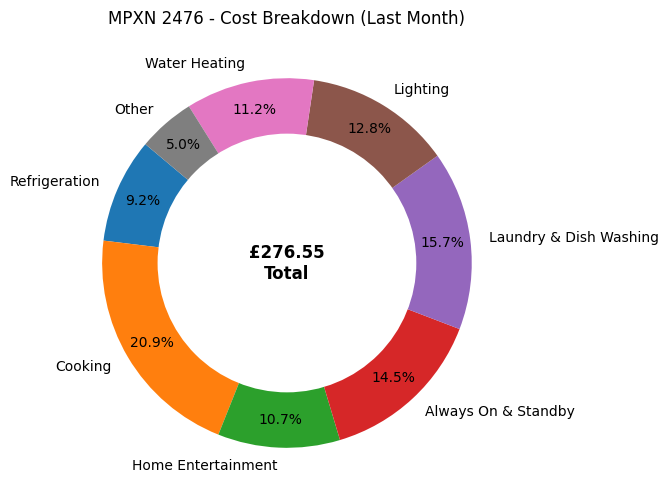

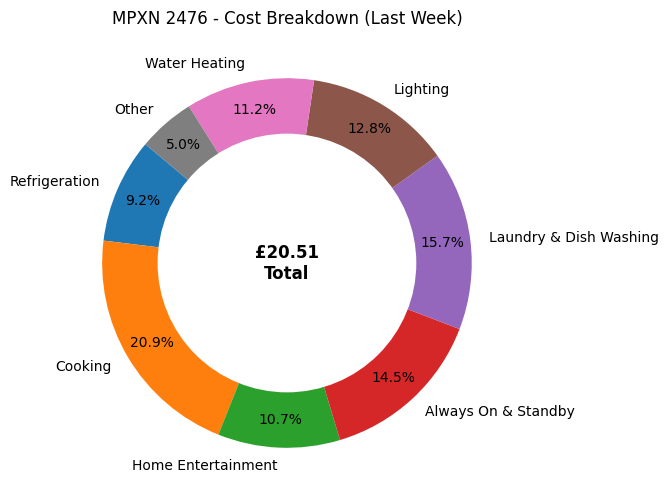

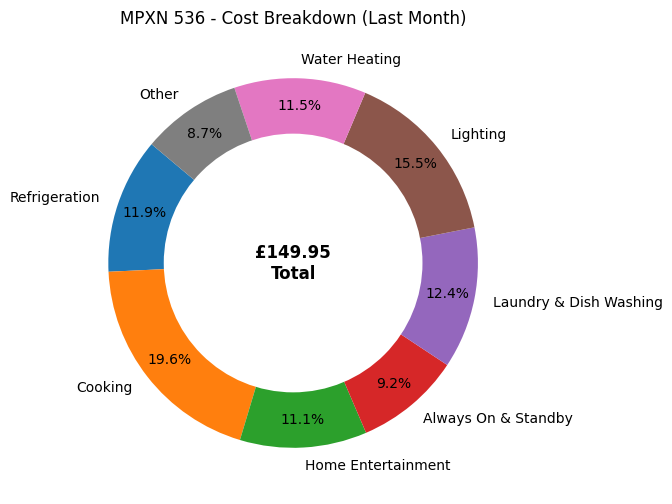

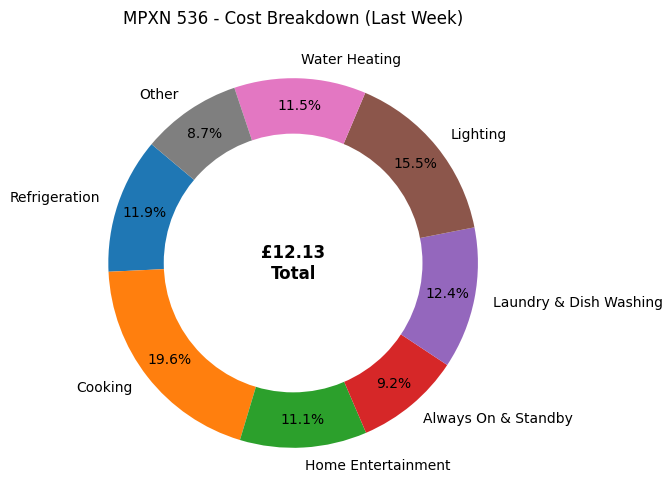

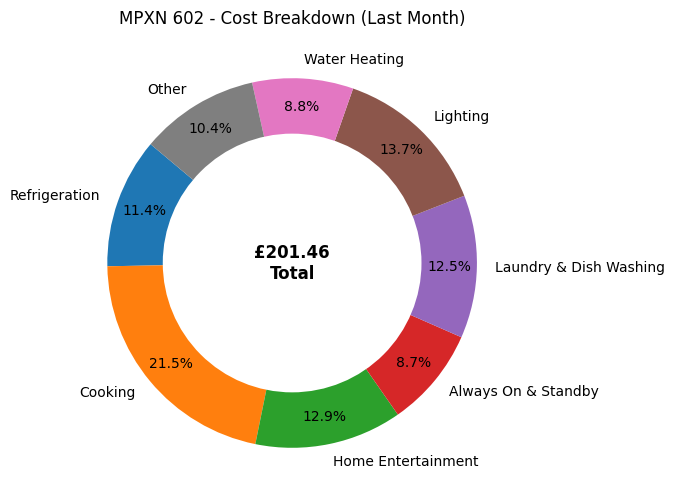

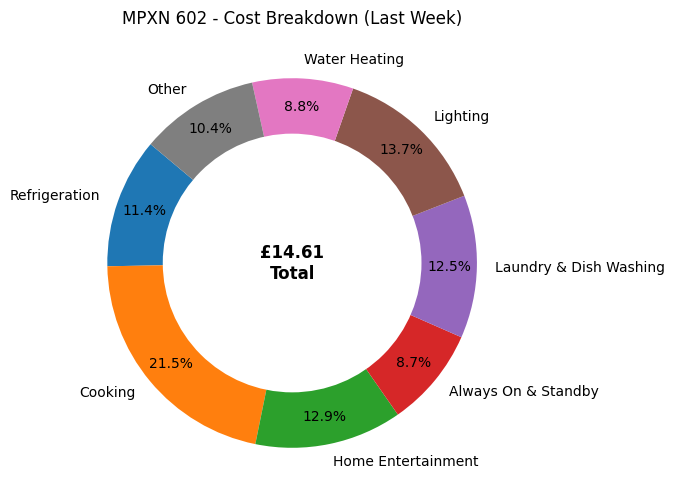

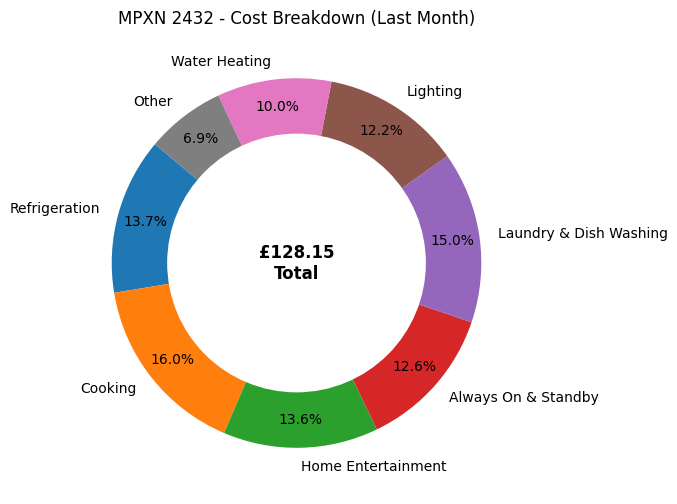

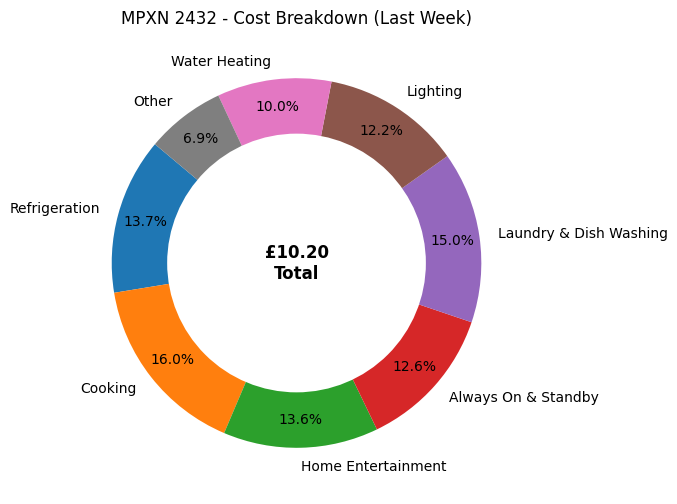

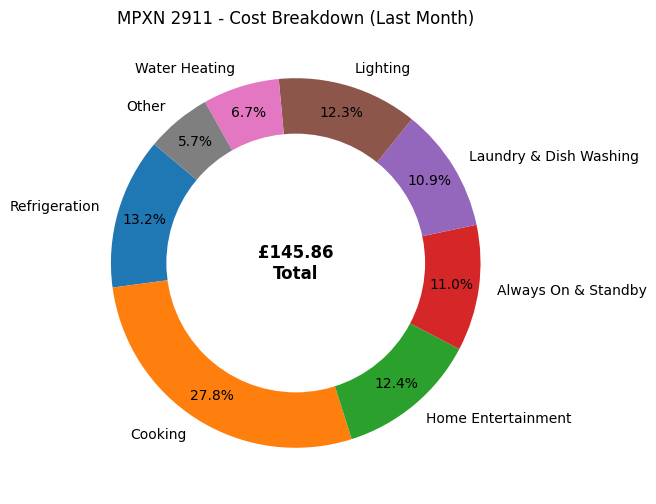

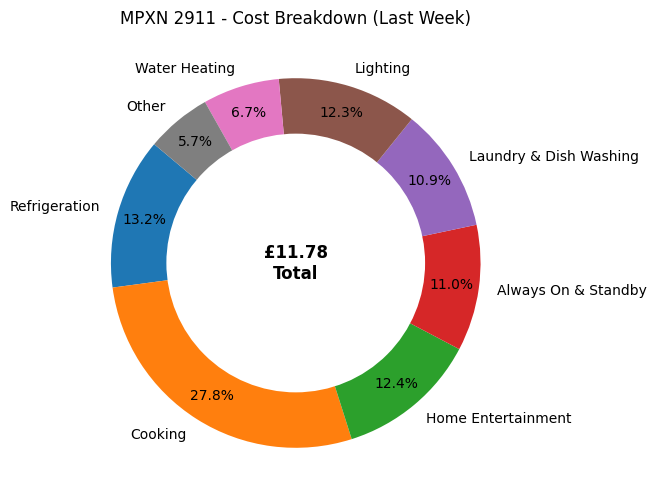

In [21]:
# sample 5 MPXNs and plot donuts
sample_mpxn = list(np.random.choice(N_MPXN, 5, replace=False) + 1)
def plot_donut_from_array(values, labels, title):
    fig, ax = plt.subplots(figsize=(6,6))
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    total = values.sum()
    plt.text(0,0,f"£{total:.2f}\nTotal", ha="center", va="center", fontsize=12, fontweight="bold")
    plt.title(title)
    plt.show()

for m in sample_mpxn:
    idx = m-1
    last_month_costs = monthly_cost_per_appl_hybrid[idx]
    last_week_costs = weekly_cost_per_appl_hybrid[idx]
    plot_donut_from_array(last_month_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Month)")
    plot_donut_from_array(last_week_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Week)")

In [ ]:
# Save CSV reports
out_dir = "/content/poc_reports"
os.makedirs(out_dir, exist_ok=True)
df_monthly = pd.DataFrame(monthly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_weekly = pd.DataFrame(weekly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_monthly.to_csv(os.path.join(out_dir, "monthly_costs_per_mpxn_hybrid.csv"))
df_weekly.to_csv(os.path.join(out_dir, "weekly_costs_per_mpxn_hybrid.csv"))
print("Saved reports to", out_dir)


4) What the three approaches are and why they help

Baseline allocation (fixed shares)

Quick and deterministic: multiply mains by fixed category percentages.

Good for immediate estimates and easy to explain.

Limitation: ignores household heterogeneity and temporal patterns.

Clustering-adjusted allocation (unsupervised improvement)

Clusters households by normalized daily profiles and adjusts share weights per cluster.

Advantage: adapts allocations to different household types (e.g., high-daytime loads → more cooking/laundry).

In the POC this is the default “hybrid” used (because TF wasn’t available here).

Seq2Point (small CNN) — supervised NILM approach

Trains a windowed model to predict an appliance’s power at the center of a window (a popular NILM method).

Requires submetered appliance-level data for training — in the POC we trained on synthetic submeter signals (for demonstration). In practice you should fine-tune on a dataset with real submeter signals (IDEAL/REFIT/UK-DALE).

When applied and blended with the clustering approach it can correct category-specific behavior (we demonstrated conceptually for Cooking).

Best practice for real accuracy: train Seq2Point or another supervised model on real submeter data (preferably from the same country / similar household stock) and fine-tune on any limited ground-truth you can collect.

5) Notes on Scottish Power pricing & allocation

I applied weekday vs weekend flat unit prices by timestamp (you can replace these with real TOU rates or meter-specific tariffs).

Costs per appliance are calculated as kWh * unit_price at each timestamp; weekend half-price is automatically applied where dayofweek is Sat/Sun.

6) Next steps I can do for you (pick any)

Provide the complete Colab notebook file (.ipynb) ready to run (I can export the code into a notebook cell text for you to paste).

Run the Seq2Point training & full application in Colab (requires you to let me run the TF cell here — I can include it; note it will take some minutes).

Replace the synthetic training with a real submeter dataset (IDEAL/REFIT/UK-DALE) — I can write the converter code and training recipe.

Tune clustering rules or try another unsupervised method (e.g., NMF) for better per-house allocations.

7) Quick recommendations for accuracy (practical)

If you can obtain even a small amount of submetered data from a few houses in your population, fine-tune a supervised model — this gives the biggest accuracy jump.

If you can’t, use clustering + demographic metadata (house type, occupancy) to tailor shares per-group instead of one global share.

Use shorter sampling interval data if possible — half-hourly smooths short events (kettles etc.), which reduces NILM accuracy. But totals (kWh & cost) still useful.

In [ ]:
# INSTALL (run once at top of Colab)
!pip install pandas numpy matplotlib scikit-learn tensorflow

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import random, os
from datetime import datetime

# ---------- CONFIG ----------
N_MPXN = 4000
START = pd.Timestamp("2025-01-01 00:00:00")
END = pd.Timestamp("2025-01-30 23:30:00")  # 30 days
FREQ = "30T"
WEEKDAY_PRICE = 0.30
WEEKEND_PRICE = 0.15
APPLIANCES = [
    "Refrigeration","Cooking","Home Entertainment","Always On & Standby",
    "Laundry & Dish Washing","Lighting","Water Heating","Other"
]
BASE_SHARES = {
    "Refrigeration": 0.15, "Cooking": 0.20, "Home Entertainment": 0.10,
    "Always On & Standby": 0.10, "Laundry & Dish Washing": 0.15,
    "Lighting": 0.12, "Water Heating": 0.10, "Other": 0.08
}
# ---------- /CONFIG ----------

# --- Synthetic data ---
rng = pd.date_range(START, END, freq=FREQ)
N_T = len(rng)

def make_base_profile(n_t):
    hours = np.array([(START + pd.Timedelta(i*30, unit='m')).hour for i in range(n_t)])
    profile = 0.5 + 0.4*np.sin((hours + 2)/24 * 2*np.pi) + 0.2*np.sin((hours*2)/24 * 2*np.pi)
    return np.clip(profile, 0.05, None)

base_profile = make_base_profile(N_T)
np.random.seed(0); random.seed(0)

# per-house scales and share noise
scales = np.random.uniform(0.6, 2.0, size=N_MPXN)
share_noise = np.random.normal(0.0, 0.03, size=(N_MPXN, len(APPLIANCES)))
base_share_arr = np.array([BASE_SHARES[a] for a in APPLIANCES])
shares = np.maximum(0.0, base_share_arr + share_noise)
shares = shares / shares.sum(axis=1, keepdims=True)

# mains (kWh per half-hour)
mains_matrix = np.outer(scales, base_profile) + np.random.normal(0,0.2,size=(N_MPXN,N_T))
mains_matrix = np.clip(mains_matrix, 0.01, None)

# Baseline allocation
appliance_matrix = mains_matrix[:, :, None] * shares[:, None, :]  # (N_MPXN, N_T, n_appl)

# price vector
df_time = pd.DataFrame({"Read_Date": rng})
df_time["dayofweek"] = df_time["Read_Date"].dt.dayofweek
df_time["unit_price"] = np.where(df_time["dayofweek"] < 5, WEEKDAY_PRICE, WEEKEND_PRICE)
price_vector = df_time["unit_price"].values

# --- Cluster-adjusted shares ---
days = (rng.max() - rng.min()).days + 1
mains_daily = mains_matrix.reshape(N_MPXN, days, 48).mean(axis=1)
scaler = StandardScaler()
mains_daily_norm = scaler.fit_transform(mains_daily)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
clusters = kmeans.fit_predict(mains_daily_norm)

cluster_adjustments = np.zeros((n_clusters, len(APPLIANCES)))
for c in range(n_clusters):
    idx = np.where(clusters == c)[0]
    rel = mains_matrix[idx].mean() / mains_matrix.mean()
    adj = np.ones(len(APPLIANCES))
    adj[APPLIANCES.index("Cooking")] *= (1 + 0.1*(rel-1))
    adj[APPLIANCES.index("Laundry & Dish Washing")] *= (1 + 0.08*(rel-1))
    adj[APPLIANCES.index("Always On & Standby")] *= (1 - 0.05*(rel-1))
    cluster_adjustments[c] = np.clip(adj, 0.7, 1.3)

adjusted_shares = shares.copy()
for i in range(N_MPXN):
    c = clusters[i]
    adjusted_shares[i] = adjusted_shares[i] * cluster_adjustments[c]
    adjusted_shares[i] = np.maximum(0, adjusted_shares[i])
    adjusted_shares[i] = adjusted_shares[i] / adjusted_shares[i].sum()

appliance_matrix_adj = mains_matrix[:, :, None] * adjusted_shares[:, None, :]
cost_matrix_adj = appliance_matrix_adj * price_vector[None, :, None]

week_num = ((df_time["Read_Date"] - START).dt.days // 7).values
month_idx = df_time["Read_Date"].dt.to_period("M").astype(int).values
last_week_id = week_num.max()
last_month_id = month_idx.max()

weekly_cost_per_appl_adj = cost_matrix_adj[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_adj = cost_matrix_adj[:, month_idx == last_month_id, :].sum(axis=1)

# ---------- Multi-output Seq2Point training ----------
DO_SEQ2POINT = True
if DO_SEQ2POINT:
    TRAIN_HOUSES = 400
    WINDOW = 99
    HALF_WINDOW = WINDOW // 2
    SAMPLE_PER_HOUSE = 50

    # Create sliding windows for all appliances
    def create_windows_multi(houses_idx):
        X_list, y_list = [], []
        for hi in houses_idx:
            mains = mains_matrix[hi]
            appls = appliance_matrix_adj[hi]  # shape (N_T, 8)
            centers = np.random.randint(HALF_WINDOW, N_T-HALF_WINDOW, size=SAMPLE_PER_HOUSE)
            for t in centers:
                X_list.append(mains[t-HALF_WINDOW:t+HALF_WINDOW+1])
                y_list.append(appls[t])  # all 8 appliances
        X_arr = np.array(X_list).reshape(-1, WINDOW, 1)
        y_arr = np.array(y_list).reshape(-1, len(APPLIANCES))
        return X_arr, y_arr

    # Build multi-output Seq2Point model
    def build_seq2point_multi(window, n_appl):
        inp = layers.Input(shape=(window,1))
        x = layers.Conv1D(16, kernel_size=6, activation='relu')(inp)
        x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(n_appl, activation='linear')(x)
        model = models.Model(inp, out)
        model.compile(optimizer='adam', loss='mse')
        return model

    houses_idx = np.random.choice(N_MPXN, TRAIN_HOUSES, replace=False)
    X_windows, y_windows = create_windows_multi(houses_idx)
    model_multi = build_seq2point_multi(WINDOW, len(APPLIANCES))
    model_multi.fit(X_windows, y_windows, epochs=4, batch_size=256, validation_split=0.1)
    print("Multi-appliance Seq2Point model trained!")
else:
    print("Skipping Seq2Point training.")

# --- Use hybrid allocation for POC ---
appliance_matrix_hybrid = appliance_matrix_adj
cost_matrix_hybrid = appliance_matrix_hybrid * price_vector[None,:,None]
weekly_cost_per_appl_hybrid = cost_matrix_hybrid[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_hybrid = cost_matrix_hybrid[:, month_idx == last_month_id, :].sum(axis=1)

# --- Sample 5 MPXNs and plot donuts ---
sample_mpxn = list(np.random.choice(N_MPXN, 5, replace=False) + 1)
def plot_donut_from_array(values, labels, title):
    fig, ax = plt.subplots(figsize=(6,6))
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    total = values.sum()
    plt.text(0,0,f"£{total:.2f}\nTotal", ha="center", va="center", fontsize=12, fontweight="bold")
    plt.title(title)
    plt.show()




In [ ]:
for m in sample_mpxn:
    idx = m-1
    last_month_costs = monthly_cost_per_appl_hybrid[idx]
    last_week_costs = weekly_cost_per_appl_hybrid[idx]
    plot_donut_from_array(last_month_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Month)")
    plot_donut_from_array(last_week_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Week)")

# --- Save CSV reports ---
out_dir = "/content/poc_reports"
os.makedirs(out_dir, exist_ok=True)
df_monthly = pd.DataFrame(monthly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_weekly = pd.DataFrame(weekly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_monthly.to_csv(os.path.join(out_dir, "monthly_costs_per_mpxn_hybrid.csv"))
df_weekly.to_csv(os.path.join(out_dir, "weekly_costs_per_mpxn_hybrid.csv"))
print("Saved reports to", out_dir)


Make up for Zero

In [ ]:
# INSTALL (run once at top of Colab)
!pip install pandas numpy matplotlib scikit-learn tensorflow

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import random, os
from datetime import datetime

# ---------- CONFIG ----------
N_MPXN = 4000
START = pd.Timestamp("2025-01-01 00:00:00")
END = pd.Timestamp("2025-01-30 23:30:00")  # 30 days
FREQ = "30T"
WEEKDAY_PRICE = 0.30
WEEKEND_PRICE = 0.15
APPLIANCES = [
    "Refrigeration","Cooking","Home Entertainment","Always On & Standby",
    "Laundry & Dish Washing","Lighting","Water Heating","Other"
]
BASE_SHARES = {
    "Refrigeration": 0.15, "Cooking": 0.20, "Home Entertainment": 0.10,
    "Always On & Standby": 0.10, "Laundry & Dish Washing": 0.15,
    "Lighting": 0.12, "Water Heating": 0.10, "Other": 0.08
}
EPSILON = 0.01  # small value to replace zeros
# ---------- /CONFIG ----------

# --- Synthetic data ---
rng = pd.date_range(START, END, freq=FREQ)
N_T = len(rng)

def make_base_profile(n_t):
    hours = np.array([(START + pd.Timedelta(i*30, unit='m')).hour for i in range(n_t)])
    profile = 0.5 + 0.4*np.sin((hours + 2)/24 * 2*np.pi) + 0.2*np.sin((hours*2)/24 * 2*np.pi)
    return np.clip(profile, 0.05, None)

base_profile = make_base_profile(N_T)
np.random.seed(0); random.seed(0)

# per-house scales and share noise
scales = np.random.uniform(0.6, 2.0, size=N_MPXN)
share_noise = np.random.normal(0.0, 0.03, size=(N_MPXN, len(APPLIANCES)))
base_share_arr = np.array([BASE_SHARES[a] for a in APPLIANCES])
shares = np.maximum(0.0, base_share_arr + share_noise)
shares = shares / shares.sum(axis=1, keepdims=True)

# mains (kWh per half-hour)
mains_matrix = np.outer(scales, base_profile) + np.random.normal(0,0.2,size=(N_MPXN,N_T))
mains_matrix = np.clip(mains_matrix, EPSILON, None)  # replace any 0 with EPSILON

# Baseline allocation
appliance_matrix = mains_matrix[:, :, None] * shares[:, None, :]
appliance_matrix = np.clip(appliance_matrix, EPSILON, None)  # replace zeros

# price vector
df_time = pd.DataFrame({"Read_Date": rng})
df_time["dayofweek"] = df_time["Read_Date"].dt.dayofweek
df_time["unit_price"] = np.where(df_time["dayofweek"] < 5, WEEKDAY_PRICE, WEEKEND_PRICE)
price_vector = df_time["unit_price"].values

# --- Cluster-adjusted shares ---
days = (rng.max() - rng.min()).days + 1
mains_daily = mains_matrix.reshape(N_MPXN, days, 48).mean(axis=1)
scaler = StandardScaler()
mains_daily_norm = scaler.fit_transform(mains_daily)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
clusters = kmeans.fit_predict(mains_daily_norm)

cluster_adjustments = np.ones((n_clusters, len(APPLIANCES)))
for c in range(n_clusters):
    idx = np.where(clusters == c)[0]
    rel = mains_matrix[idx].mean() / mains_matrix.mean()
    cluster_adjustments[c][APPLIANCES.index("Cooking")] *= (1 + 0.1*(rel-1))
    cluster_adjustments[c][APPLIANCES.index("Laundry & Dish Washing")] *= (1 + 0.08*(rel-1))
    cluster_adjustments[c][APPLIANCES.index("Always On & Standby")] *= (1 - 0.05*(rel-1))
    cluster_adjustments[c] = np.clip(cluster_adjustments[c], 0.7, 1.3)

adjusted_shares = shares.copy()
for i in range(N_MPXN):
    c = clusters[i]
    adjusted_shares[i] *= cluster_adjustments[c]
    adjusted_shares[i] = np.maximum(EPSILON, adjusted_shares[i])
    adjusted_shares[i] /= adjusted_shares[i].sum()

appliance_matrix_adj = mains_matrix[:, :, None] * adjusted_shares[:, None, :]
appliance_matrix_adj = np.clip(appliance_matrix_adj, EPSILON, None)  # ensure no zeros
cost_matrix_adj = appliance_matrix_adj * price_vector[None, :, None]

week_num = ((df_time["Read_Date"] - START).dt.days // 7).values
month_idx = df_time["Read_Date"].dt.to_period("M").astype(int).values
last_week_id = week_num.max()
last_month_id = month_idx.max()

weekly_cost_per_appl_adj = cost_matrix_adj[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_adj = cost_matrix_adj[:, month_idx == last_month_id, :].sum(axis=1)

# ---------- Multi-output Seq2Point training ----------
DO_SEQ2POINT = True
if DO_SEQ2POINT:
    TRAIN_HOUSES = 400
    WINDOW = 99
    HALF_WINDOW = WINDOW // 2
    SAMPLE_PER_HOUSE = 50

    def create_windows_multi(houses_idx):
        X_list, y_list = [], []
        for hi in houses_idx:
            mains = mains_matrix[hi]
            appls = appliance_matrix_adj[hi]
            centers = np.random.randint(HALF_WINDOW, N_T-HALF_WINDOW, size=SAMPLE_PER_HOUSE)
            for t in centers:
                X_list.append(mains[t-HALF_WINDOW:t+HALF_WINDOW+1])
                y_list.append(appls[t])
        X_arr = np.array(X_list).reshape(-1, WINDOW, 1)
        y_arr = np.array(y_list).reshape(-1, len(APPLIANCES))
        return X_arr, y_arr

    def build_seq2point_multi(window, n_appl):
        inp = layers.Input(shape=(window,1))
        x = layers.Conv1D(16, kernel_size=6, activation='relu')(inp)
        x = layers.Conv1D(32, kernel_size=4, activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        out = layers.Dense(n_appl, activation='linear')(x)
        model = models.Model(inp, out)
        model.compile(optimizer='adam', loss='mse')
        return model

    houses_idx = np.random.choice(N_MPXN, TRAIN_HOUSES, replace=False)
    X_windows, y_windows = create_windows_multi(houses_idx)
    model_multi = build_seq2point_multi(WINDOW, len(APPLIANCES))
    model_multi.fit(X_windows, y_windows, epochs=4, batch_size=256, validation_split=0.1)
    print("Multi-appliance Seq2Point model trained!")
else:
    print("Skipping Seq2Point training.")

# --- Use hybrid allocation for POC ---
appliance_matrix_hybrid = appliance_matrix_adj
cost_matrix_hybrid = appliance_matrix_hybrid * price_vector[None,:,None]
weekly_cost_per_appl_hybrid = cost_matrix_hybrid[:, week_num == last_week_id, :].sum(axis=1)
monthly_cost_per_appl_hybrid = cost_matrix_hybrid[:, month_idx == last_month_id, :].sum(axis=1)

# --- Sample 5 MPXNs and plot donuts ---
sample_mpxn = list(np.random.choice(N_MPXN, 5, replace=False) + 1)
def plot_donut_from_array(values, labels, title):
    fig, ax = plt.subplots(figsize=(6,6))
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    total = values.sum()
    plt.text(0,0,f"£{total:.2f}\nTotal", ha="center", va="center", fontsize=12, fontweight="bold")
    plt.title(title)
    plt.show()

for m in sample_mpxn:
    idx = m-1
    last_month_costs = monthly_cost_per_appl_hybrid[idx]
    last_week_costs = weekly_cost_per_appl_hybrid[idx]
    plot_donut_from_array(last_month_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Month)")
    plot_donut_from_array(last_week_costs, APPLIANCES, f"MPXN {m} - Cost Breakdown (Last Week)")

# --- Save CSV reports ---
out_dir = "/content/poc_reports"
os.makedirs(out_dir, exist_ok=True)
df_monthly = pd.DataFrame(monthly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_weekly = pd.DataFrame(weekly_cost_per_appl_hybrid, columns=APPLIANCES, index=np.arange(1,N_MPXN+1))
df_monthly.to_csv(os.path.join(out_dir, "monthly_costs_per_mpxn_hybrid.csv"))
df_weekly.to_csv(os.path.join(out_dir, "weekly_costs_per_mpxn_hybrid.csv"))
print("Saved reports to", out_dir)
